In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import math
import time

from datetime import datetime, timedelta
import sys
import os
import glob

import matplotlib.pyplot as plt

# reduce warnings (less pink)
import warnings
warnings.filterwarnings('ignore')

print('Loaded Libraries')

Loaded Libraries


# Important User-Defined Options

In [3]:
Input_Data_Path = '/Users/bbass/Downloads'
Write_Model_Output_To = '/Users/bbass/Downloads/Test_Run_MLM'

### If Change Initial Water Level, Should Update Start Year as Well
Initial_Water_Level = 6383.3
Start_Year = 2025 # Earliest Start Year = 1955, Last Start Year = 2098

In [4]:
### make output folder if does not exist
if not os.path.exists(Write_Model_Output_To):
    os.makedirs(Write_Model_Output_To)
    print(f'Made Folder to Store Results: {Write_Model_Output_To}')

# Load Relevant Data and Model Details

In [5]:
### GCM Data
GCM_Data_Path = f'{Input_Data_Path}/For_Running_Model'
### details specific to water budget model
details_for_model = pd.read_csv(f'{Input_Data_Path}/details_for_model.csv',index_col=0)
### Observed data range of elev-vol-sa
mono_lake_storage_elev = pd.read_csv(f'{Input_Data_Path}/Mono_Lake_Area_Storage_Elev.txt',delimiter='\t')

print('Loaded Data Needed to Run Water Budget Model Below')

Loaded Data Needed to Run Water Budget Model Below


In [6]:
### First Get Information Needed for Mono Lake Level Model

### Max Number of Years for Policy Phases 
### by defining seperately, allows for policy to be set-up for max_num_years possible and then budget model simulation for different numbers of years
Max_Num_Years = (2100-1955)+1

#### this is accounted for in Lake Level Model Notebook for both GCMs and ERA5 flows into mono lake
#### optimized bias correction term
Sim_Modification_to_Ungauged_Runoff = details_for_model[details_for_model.index=='Sim_Modification_to_Ungauged_Runoff'].values[0][0]

#print('If update water level model, make sure to update error in storage AND BC to Ungauged for ERA5')
### Error Term for Observed Data
intercept_error_using_observed_inflow = details_for_model[details_for_model.index=='intercept_error_using_observed_inflow'].values[0][0]
slope_error_using_observed_inflow =  details_for_model[details_for_model.index=='slope_error_using_observed_inflow'].values[0][0]

#####################################################################

### Modification to Mono Lake Evaporation based on salinity at different lake elevations

### Added this option to adjust evaporation (not used)
Assumed_Historical_Mono_Lake_Evaporation_Average = 47.25

### Data needed if want to have variable ungauged surface area
Ungauged_Assumed_Area = 1299.0291932258256 * 247.105 ### Acres
Mono_SHP_Area = 39841.920314190225 ### Acres ### SHP Area for Mono Lake (corresonds to 6374 ft)...in reality ungauged area is larger since initial water level = 6383.7 ft

GW_Export = 5500

min_salinity_level = 6360
min_salinity_value = 0.93
max_salinity_level = 6405
max_salinity_value = 0.97

### Assume a salinity-elevation relationship
m_salinity = (max_salinity_value-min_salinity_value) / (max_salinity_level-min_salinity_level)  ### corresponding salinity / corresponding elevations
b_salinity = min_salinity_value - m_salinity * min_salinity_level

# Define the range of elevations
elevations = np.linspace(6350, 6410, 100)
# Calculate the salinity for each elevation using the line equation
salinity = m_salinity * elevations + b_salinity

### caps on salinity (updated this from 0.93 to 0.94)
salinity = np.where(salinity<min_salinity_value,min_salinity_value,salinity)
salinity = np.where(salinity>max_salinity_value,max_salinity_value,salinity)

############# Mono Lake Elev-Vol-SA

### Get fit between elevation and storage/surface area
df = mono_lake_storage_elev.copy()
df = df.sort_values('elev_ft')  ### also sorts volume

# Fit a quadratic polynomial to the data
obs_polyfit_elev_storage = np.polyfit(df['elev_ft'], df['volume_ac_ft'], 2)
# get coefficients so can apply model
obs_polyfit_elev_storage = np.poly1d(obs_polyfit_elev_storage)

# Calculate the slopes based on the first two and last two values of the observed data
obs_elev_storage_slope_start = (df['volume_ac_ft'].iloc[1] - df['volume_ac_ft'].iloc[0]) / (df['elev_ft'].iloc[1] - df['elev_ft'].iloc[0])
obs_elev_storage_slope_end = (df['volume_ac_ft'].iloc[-1] - df['volume_ac_ft'].iloc[-2]) / (df['elev_ft'].iloc[-1] - df['elev_ft'].iloc[-2])

# use intercept at y_min, y_max
storage_obs_min = np.min(df['volume_ac_ft'])
storage_obs_max = np.max(df['volume_ac_ft'])

elev_obs_min = np.min(df['elev_ft'])
elev_obs_max = np.max(df['elev_ft'])

# Define the linear extrapolation function
def polyfit_elev_storage(x):
    
    '''
    If value smaller or larger than observed range, then use linear slope to extrapolate rather than polynomial which can extrapolate in undesirable manner
    '''
    
    storage_vals = np.where(x < elev_obs_min,
                           storage_obs_min + obs_elev_storage_slope_start * (x - elev_obs_min),
                           np.where(x > elev_obs_max,
                                    storage_obs_max + obs_elev_storage_slope_end * (x - elev_obs_max),
                                    obs_polyfit_elev_storage(x)))
    
    storage_vals = np.where(storage_vals < 0, 0, storage_vals)
    
    return storage_vals




### Get fit between storage and elevation

### from above slope extended from observed data, determine at what elevation of mono lake the volume is zero
min_mono_lake_elevation = elev_obs_min - (storage_obs_min / obs_elev_storage_slope_start)

# Fit a quadratic polynomial to the data
obs_polyfit_storage_elev = np.polyfit(df['volume_ac_ft'], df['elev_ft'], 3)
# get coefficients so can apply model
obs_polyfit_storage_elev = np.poly1d(obs_polyfit_storage_elev)

# Calculate the slopes based on the first two and last two values of the observed data
obs_storage_elev_slope_start = (df['elev_ft'].iloc[1] - df['elev_ft'].iloc[0]) / (df['volume_ac_ft'].iloc[1] - df['volume_ac_ft'].iloc[0])
obs_storage_elev_slope_end = (df['elev_ft'].iloc[-1] - df['elev_ft'].iloc[-2]) / (df['volume_ac_ft'].iloc[-1] - df['volume_ac_ft'].iloc[-2])

# Define the linear extrapolation function
def polyfit_storage_elev(x):
    
    '''
    If value smaller or larger than observed range, then use linear slope to extrapolate rather than polynomial which can extrapolate in undesirable manner
    '''
    
    elev_vals = np.where(x < storage_obs_min,
                        elev_obs_min + obs_storage_elev_slope_start * (x - storage_obs_min),
                        np.where(x > storage_obs_max,
                                 elev_obs_max + obs_storage_elev_slope_end * (x - storage_obs_max),
                                 obs_polyfit_storage_elev(x)))
    
    elev_vals = np.where(elev_vals < min_mono_lake_elevation, min_mono_lake_elevation, elev_vals)
    
    return elev_vals


############ Fit Function Using Volume to Surface Area of Mono Lake

### from above slope extended from observed data, determine at what elevation of mono lake the volume is zero
min_mono_lake_elevation = elev_obs_min - (storage_obs_min / obs_elev_storage_slope_start)

# Fit a quadratic polynomial to the data
obs_polyfit_storage_sa = np.polyfit(df['volume_ac_ft'], df['surface_area_acres'], 8)
# get coefficients so can apply model
obs_polyfit_storage_sa = np.poly1d(obs_polyfit_storage_sa)

# Calculate the slopes based on the first two and last two values of the observed data
#obs_storage_sa_slope_start = (df['surface_area_acres'].iloc[1] - df['surface_area_acres'].iloc[0]) / (df['volume_ac_ft'].iloc[1] - df['volume_ac_ft'].iloc[0])
obs_storage_sa_slope_start = (df['surface_area_acres'].iloc[1] - df['surface_area_acres'].iloc[0]) / (df['volume_ac_ft'].iloc[1] - df['volume_ac_ft'].iloc[0])
obs_storage_sa_slope_end = (df['surface_area_acres'].iloc[-1] - df['surface_area_acres'].iloc[-2]) / (df['volume_ac_ft'].iloc[-1] - df['volume_ac_ft'].iloc[-2])

### get min/max of surface area in observed data
sa_obs_min = np.min(df['surface_area_acres'])
sa_obs_max = np.max(df['surface_area_acres'])

# Define the linear extrapolation function
def polyfit_vol_surface_area(x):
    
    '''
    If value smaller or larger than observed range, then use linear slope to extrapolate rather than polynomial which can extrapolate in undesirable manner
    '''
    
    sa_vals = np.where(x < storage_obs_min,
                      sa_obs_min + obs_storage_sa_slope_start * (x - storage_obs_min),
                      np.where(x > storage_obs_max,
                               sa_obs_max + obs_storage_sa_slope_end * (x - storage_obs_max),
                               obs_polyfit_storage_sa(x)))
    
    sa_vals = np.where(x < 0, 0, sa_vals)
    
    return sa_vals

# Policy Variations

## LADWP Defined Policies

In [7]:
def create_dataarray(phases_data, Dyn_Type=None, Phase_Thresh=None):
    """
    Create an xarray DataArray with the specified dimensions.
    
    Parameters:
    phases_data (dict): A dictionary where keys are phase numbers and values are dictionaries
                        with levels as keys and lists representing the RYT values for 'level' and 'year_type'.
    Dyn_Type (str, optional): A string indicating the type of dynamic ('year', 'level', 'year_level').
                              Only needed if more than 1 phase is defined.
    Phase_Thresh (list, optional): A list of thresholds for the start of each phase.
                                   Only needed if more than 1 phase is defined.
    
    Returns:
    xr.DataArray: The created DataArray with dimensions ('phase', 'level', 'year_type') and attached attributes.
    """
    # Define year_type labels
    year_types = ['Dry', 'Dry-Normal', 'Normal', 'Wet-Normal', 'Wet', 'Extreme-Wet']
    
    # Determine the global minimum and maximum levels across all phases
    global_min_level = min(min(levels.keys()) for levels in phases_data.values())
    global_max_level = max(max(levels.keys()) for levels in phases_data.values()) + 1
    
    # Create a list to store each phase's data as a DataArray
    phase_dataarrays = []
    phase_numbers = sorted(phases_data.keys())
    
    for phase in phase_numbers:
        phase_info = phases_data[phase]
        sorted_levels = sorted(phase_info.keys())
        first_defined_level = sorted_levels[0]
        
        # Initialize data array (rows based on levels, columns based on year_types) with np.nan
        data = np.full((global_max_level - global_min_level, len(year_types)), np.nan)
        
        # Set all levels below the first defined level to zero
        # this should only happen if another phase has a higher level threshold for zero exports
        zero_values = [0] * len(year_types)
        if first_defined_level > global_min_level:
            data[:first_defined_level - global_min_level] = zero_values
        
        # Apply the values to the levels
        for i, level in enumerate(sorted_levels):
            values = phase_info[level]
            next_level = sorted_levels[i + 1] if i + 1 < len(sorted_levels) else global_max_level
            ### apply values across range of current next level
            data[level - global_min_level:next_level - global_min_level] = values
        
        levels = np.arange(global_min_level, global_max_level)
        
        # Create a DataArray for this phase
        da = xr.DataArray(data, coords=[levels, year_types], dims=['level', 'year_type'])
        phase_dataarrays.append(da)
    
    # Concatenate all phase DataArrays along a new 'phase' dimension
    data_array = xr.concat(phase_dataarrays, dim='phase')
    data_array['phase'] = phase_numbers
    
    # Determine attributes based on the number of phases
    if len(phase_numbers) == 1:
        attributes = {
            'Dynamic': 0,
            'Dyn_Type': np.nan,
            'Phase_Num': np.nan,
            'Phase_Thresh': np.nan
        }
    else:
        attributes = {
            'Dynamic': 1,
            'Dyn_Type': Dyn_Type,
            'Phase_Num': len(phase_numbers),
            'Phase_Thresh': Phase_Thresh
        }
    
    # Attach attributes to the DataArray
    data_array.attrs = attributes
    
    return data_array

In [8]:
### Create and Put DWP Policies into Dictionary
### Note, here DWP policies created so highest water level exports continue for 6391 and above
### However, when running WBM can define if Post-Transition Policy or Another User-Defined Policy is Used
### (e.g. so can either have: i) continuation of policy, ii) post-transtion policy or iii) other user-defined policy

Policy_Data = {}

### Existing
A1 = {
    1: 
    {6376: [0]*6,
     6377: [4500]*6,
     6380: [16000]*6,
     6391: [16000]*6
     }
     }

data_array = create_dataarray(A1)
Policy_Data['A1'] = data_array

In [9]:
#### UNCOMMENT BELOW IF WANT TO RUN EXISTING POST-TRANSITION EXPORT CRITERIA

# ### Post-Transtion
# A8 = {
#     1:
#     {6387: [0]*6,
#      6388: [10000]*6,
#      6391: [np.inf]*6,
#      }
#      }

# data_array = create_dataarray(A8)

# Post_Transition_Policy = data_array

# Post_Transition_Data = {}

# Post_Transition_Data['Existing'] = Post_Transition_Policy

In [10]:
### DISPLAY EXPORTS ALLOWED FOR EACH WATER LEVEL

def df_of_policy(policy):

    # Convert the DataArray to a DataFrame
    df = policy.to_dataframe(name='Value')

    # Reset the index to make the data more user-friendly
    df.reset_index(inplace=True)

    df = df.rename(columns={'level':'Water Level','year_type':'RYT'})

    # Display the DataFrame in a format that's easy to read
    df_pivot = df.pivot(index='Water Level', columns='RYT', values='Value')
    
    # Preserve the order of the original 'year_type' from the DataArray
    original_order = policy.coords['year_type'].values  # Get the original order from the DataArray
    df_pivot = df_pivot.reindex(columns=original_order)  # Reorder columns in the pivoted DataFrame

    return df_pivot


# Function to aggregate consecutive rows with identical values across all columns
def aggregate_consecutive_rows(df):
    
    # Create an empty DataFrame to store the results
    result = pd.DataFrame(columns=df.columns)
    # Initialize tracking variables
    start = df.index[0]
    prev_row = df.iloc[0]
    
    for i in range(1, len(df)):
        current_row = df.iloc[i]
        # If the current row is different from the previous row, record the range
        if not current_row.equals(prev_row):
            if start == df.index[i-1]:
                index_label = f"{start}"
            else:
                index_label = f"{start}–{df.index[i-1]}"
            result.loc[index_label] = prev_row
            start = df.index[i]
        prev_row = current_row
    
    # Add the last group
    if start == df.index[-1]:
        index_label = f"{start}"
    else:
        index_label = f"{start}–{df.index[-1]}"
    result.loc[index_label] = prev_row

    return result


def return_for_multiple_phases(policy):

    aggregated_phase_dfs = {}

    for phase in policy.phase:

        df = policy.sel(phase=phase)

        # get df of policy
        df = df_of_policy(df)

        # Aggregate rows
        aggregated_df = aggregate_consecutive_rows(df)

        # Dynamically identify the minimum and maximum water levels
        min_water_level = df.index.min()
        max_water_level = df.index.max()

        # Update the first and last index with <=Min and >=Max
        aggregated_df.index = aggregated_df.index.str.replace(f'{min_water_level}', f'≤{min_water_level}')
        #aggregated_df.index = aggregated_df.index.str.replace(f'{max_water_level}–{max_water_level}', f'≥{max_water_level}')

        # update name for rows/col
        aggregated_df.columns.name = 'Water Level / RYT'

        int_phase = int(phase.values)
        
        # Store the aggregated DataFrame for this phase
        aggregated_phase_dfs[int_phase] = aggregated_df
        
    ### if single phase then just return df
    if int_phase == 1:
        aggregated_phase_dfs = aggregated_phase_dfs[1]

    return aggregated_phase_dfs

In [11]:
# ### Display an example policy
# tmp_df = return_for_multiple_phases(Policy_Data['A4'])
# #tmp_df = return_for_multiple_phases(User_Post_Transition_Policy)
# tmp_df

# Percent Reduction Runs with Uniform Post-Transition Values

In [12]:
## THIS CODE IS USED TO CREATE PERCENT REDUCTION PRE-TRANSITION POLICIES
## WILL THEN NEED TO MAKE POST-TRANSITION POLICIES

### Just need percent reductions to this (5% increments from 0 to 100% reduction)

import copy

for percent in range(0,105,5):
    
    ds = copy.deepcopy(Policy_Data['A1'])

    # keep attrs on Dataset and all DataArrays during arithmetic
    with xr.set_options(keep_attrs=True):
        ds = ds * (percent / 100.0)
    
    percent_reduction = 100 - percent
    
    key = f'{percent_reduction}_Percent_Reduction'
    
    # Store the result in the Policy_Data dictionary
    Policy_Data[key] = ds

print('Done')

Done


In [13]:
### don't need A1 since have it (it is 0_perc_reduction)
Policy_Data.pop('A1')
Policy_Data.keys()

dict_keys(['100_Percent_Reduction', '95_Percent_Reduction', '90_Percent_Reduction', '85_Percent_Reduction', '80_Percent_Reduction', '75_Percent_Reduction', '70_Percent_Reduction', '65_Percent_Reduction', '60_Percent_Reduction', '55_Percent_Reduction', '50_Percent_Reduction', '45_Percent_Reduction', '40_Percent_Reduction', '35_Percent_Reduction', '30_Percent_Reduction', '25_Percent_Reduction', '20_Percent_Reduction', '15_Percent_Reduction', '10_Percent_Reduction', '5_Percent_Reduction', '0_Percent_Reduction'])

In [15]:
### Post-Transition Policies

#1,000 AF increment with max of 50,000 AF 

Post_Transition_Data = {}

for val in range(0,51000,1000):

    tmp_policy = {
        1:
        {6390: [0]*6,
         6391: [val]*6,
         }
         }

    data_array = create_dataarray(tmp_policy)
    
    key = f'{val}_Exports_Allowed_6391_and_Up'

    Post_Transition_Data[key] = data_array
    
print('Created Post-Transition Exports')

Created Post-Transition Exports


In [17]:
### Function to Determine Export Limit for any Input Policy ###

## Outputs the export limit based on policy xarray and conditions fed in from the model for each year ##
## For Static Policy: Depends on Lake Level and RYT
## For Dynamic Policy: Additionally Depends on Years into Simulation and Lake Level Condition to Determine Phase

## Function Inputs ##

# Policy_Data : xarray for specified policy (either user defined policy or existing LADWP policies)
# policy_name : name of LADWP policy (A1-A10) or "NA" for user defined policy 
# level : input lake level from model 
# year : input current year from model
# year_type_check : input RYT from model
# level_hist : list of all previous lake levels from 2024 - current year 

## Function Outputs ##
# export threshold value

def find_policy_value_updated(Policy_Data,level, year, year_type_check, level_hist, policy_name=None):
    
    '''
    Policy_Data can be an xarray datarray or dataset
    
    If dataset, then need to define policy_name so can extract the policy (as a variable) from the dataset
    
    '''
    
    #selects policy 
    if policy_name == None:
        if isinstance(Policy_Data, xr.DataArray):
            policy = Policy_Data
        else:
            sys.exit('Need to Name Policy To Extract from Dataset')
    else:
        policy = Policy_Data[policy_name]#Policy_Data[policy_name]

    #looks up policy attributes to check if its a dynamic policy 
    policy_attr = policy.attrs
    check_dyn = policy_attr["Dynamic"]

    #Caps upper and lower bounds of lake level ranges
    #note, this is only relevant for determining exports
    
    ### use exports defined at lowest level if below that level (would be zero exports)
    if level < float(np.min(policy.level).values):
        level = float(np.min(policy.level).values)
    ### use exports defined at highest level if above that level
    if level > float(np.max(policy.level).values):
        level = float(np.max(policy.level).values)

    #Calculates years passed to use in dynamic policies based on time
    years_passed = year - Start_Year

    #If the policy is dynamic....
    if check_dyn == 1:

        #checks policy attributes 
        dyn_type = policy_attr['Dyn_Type'] #whether policy dynamic in lake level or time
        phase_num = policy_attr['Phase_Num'] #how many phases the policy has
        phase_thresh = policy_attr['Phase_Thresh'] # list of phase thresholds for time or lake level 

        ##Changes phase number based on threshold##
        phase_check = 1

        # for dynamic policies based on time (will not check if a water level has been met or not!)
        # A9 and A10
        if dyn_type == "year":
            for i in range(phase_num-1):
                if years_passed > phase_thresh[i]:
                    phase_check+=1

        # this is the main dynamic condition used right now
        # will check if a water level has been met or not!
        # if not, then will shift to next phase if user-defined years have passed
        # note, once stop_level (e.g. 6391) is reached will stop shifting phases
        elif dyn_type == "year_level":
            level_stop = policy_attr["Stop_Level"]
            dyn_level_check = max(level_hist)
            if dyn_level_check >= level_stop:
                ### check years passed since maximum water level above level_stop (e.g. 6391 ft.)
                ### this will then be used to select policy phase below
                ### removed +1 to line of code below
                years_passed = (level_hist.index(dyn_level_check))
            for i in range(phase_num-1):
                ### here loops from 0 to max number of phases
                ### issue appears that years_passed will be greater than first phase value of zero
                ### added i+1 to fix this issue and changed > to >=
                if years_passed >= phase_thresh[i+1]:
                    phase_check+=1

        #for dynamic policies based on level 
        #New phase triggered when lake level reached a certain level
        #check if level has ever been reached 
        # A7
        elif dyn_type == "level":
            dyn_level_check = max(level_hist)
            if phase_num == 2:
                for i in range(phase_num-1):
                    if dyn_level_check >= phase_thresh[i]:
                        phase_check+=1
            else:
                for i in range(phase_num-1):
                    print(dyn_level_check)
                    print(phase_thresh)
                    if dyn_level_check >= phase_thresh[i]:
                        phase_check+=1

        #rounds level down into integer for export selection 
        level_check = math.floor(level)

        #selects export value for particular phase, level and year type
        #note, first phase = 1 (why phase_check is set equal to 1)
        export = policy.sel(phase=phase_check).sel(level=level_check).sel(year_type=year_type_check)
    
    #If the policy is not dynamic...
    else:
        #rounds level down into integer for export selection 
        level_check = math.floor(level)
        #selects export value level and year type
        export = policy.sel(level=level_check).sel(year_type=year_type_check)
    
    #returns export limit 
    return export.values

In [18]:
### Function that Runs Model for GCM and Policy Inputs ###

# Left mostly the same with updated policy implementation using find_policy_value_updated()

def predict_Mono_Lake_Water_Level_Added_Policies(measured_Lee_Vining,
                                                 measured_Walker_Parker,
                                                 measured_inflow_not_managed_by_DWP,
                                                 measured_Grant_Lake_Spillway_Outflow,
                                                 Mono_Lake_P,
                                                 Mono_Lake_PET,
                                                 Ungauged_Runoff,
                                                 Year_Type,
                                                 Amended_License_Flow_Requirement,
                                                 ##### THESE ARE FLEXIBLE USER-DEFINED OPTIONS ###
                                                 Initial_Water_Level,
                                                 Start_Year, 
                                                 End_Year,
                                                 Export_Policy,
                                                 Exports_Post_Transition,
                                                 Policy_Name=None,
                                                 Post_Transtion_Policy_to_Use=None):
    
    '''
    Year_Type = includes information regarding runoff year type for each year based on 4-creek runoff
    
    measured variables represent actual flow after regulation
    and can be based on observed data or replaced with FNF-->Predicted Regulated Flow
    
    Post_Transtion_Policy_to_Use: 'None','D_1631','User_Defined'
    
    '''
    
    Reached_6391 = False

    dict_of_wsel_results = {}

    ### User-Defined, but Default = 2024 water level
    Current_Water_Level = Initial_Water_Level

    ### Get initial storage: Convert Water Level to Storage
    Current_Storage = polyfit_elev_storage(Current_Water_Level)
    
    ### Need to multiply P, PET (inches) by Surface Area of Mono Lake to get Total ac-ft
    Current_Surface_Area = polyfit_vol_surface_area(Current_Storage)
    
    ## ungauged area should be multiplied by this for first time-stamp
    Current_Ungauged_SA = Ungauged_Assumed_Area + (Mono_SHP_Area - Current_Surface_Area)

    ### For validating result
    Predicted_Elevation = []
    Predicted_Elevation.append(Current_Water_Level)

    ### for keeping track of storage
    Predicted_Storage = []
    Predicted_Storage.append(float(Current_Storage))
    
    ### these will be determined each year based on water levels and policies defined
    Exports_list = []
    Rush_into_Mono_list = []
    
    ### Now get ∆ Storage for each runoff year
    ### first prediction is for April 1st of following year after "Initial_Year"
    for year in range(Start_Year,End_Year+1):
        
        ### get current years regulated inflow
        measured_inflow_for_year = measured_inflow_not_managed_by_DWP[year] + measured_Lee_Vining[year] + measured_Walker_Parker[year]
        Grant_Spill_and_Outflow_for_year = measured_Grant_Lake_Spillway_Outflow[year]
        
        ############################################## Apply POLICY ##########################################
        
        if (Reached_6391 and Post_Transtion_Policy_to_Use != 'None'):
            
            
            export_allowed_for_year = find_policy_value_updated(Exports_Post_Transition, Current_Water_Level, 
                                                                year, Year_Type[year], Predicted_Elevation, Post_Transtion_Policy_to_Use)     
     
        else:
            ### typical policy prior to post-transition, or if user does not use post-transition policy
            ### recall, will use the policy defined at the highest level if water level goes above that level
            
            export_allowed_for_year = find_policy_value_updated(Export_Policy, Current_Water_Level, 
                                                                year, Year_Type[year], Predicted_Elevation, Policy_Name)
            
        ## make sure flow requirements are met
        flow_requirement_for_year = Amended_License_Flow_Requirement[year]

        ### in this case all flow should go towards meeting flow requirement (since grant lake release < SEF)
        if Grant_Spill_and_Outflow_for_year <= flow_requirement_for_year:
            export_allowed_for_year = 0
            Rush_Flow_from_Grant_for_year = Grant_Spill_and_Outflow_for_year

        ### simple case that is same as assuming flows are met where grant release is sufficient for exports and flow requirements
        ### note, this is the only case where exports_allowed_for_year are actually exported (since otherwise, depends on grant releases and flow requirements)
        ### note if in PT and export allowed = 99999 then this will not happen!
        elif Grant_Spill_and_Outflow_for_year >= (flow_requirement_for_year + export_allowed_for_year):
            Rush_Flow_from_Grant_for_year = Grant_Spill_and_Outflow_for_year - export_allowed_for_year

        ### somewhere in between
        ### figure out how much can export and meet flow requirement
        ### this logic will be what is applied for D-1631 Post Transition Policy (where all exports from grant release are allowed that exceed flow requirement)
        else:
            left_over_water = Grant_Spill_and_Outflow_for_year - flow_requirement_for_year
            export_allowed_for_year = left_over_water
            Rush_Flow_from_Grant_for_year = flow_requirement_for_year
        
        export_allowed_for_year = float(export_allowed_for_year)
        Rush_Flow_from_Grant_for_year = float(Rush_Flow_from_Grant_for_year)
        
        Exports_list.append(export_allowed_for_year)
        Rush_into_Mono_list.append(Rush_Flow_from_Grant_for_year)
        
        
        ############################################## Apply POLICY ##########################################

        ############ OTHER NON-MANAGED DATA #############

        ###### Ungauged Runoff for Year
        Ungauged_Runoff_for_year = Ungauged_Runoff[year]
        
        ############# ADDED TO UPDATE UNGAUGED SURFACE AREA EVERY YEAR #################
        Ungauged_Runoff_for_year_ft = Ungauged_Runoff_for_year
        ### multiply ft by surface area of ungauged region, which depends on mono lake current surface area
        Current_Ungauged_SA = Ungauged_Assumed_Area + (Mono_SHP_Area - Current_Surface_Area)
        Ungauged_Runoff_for_year = Ungauged_Runoff_for_year_ft * Current_Ungauged_SA

        ### Precipitation on Lake
        P_inches_for_year = Mono_Lake_P[year]  
        # convert to ft and multiply by the surface area (acres) of the lake to get ac-ft
        P_Lake_for_year = (P_inches_for_year / 12) * Current_Surface_Area  ### inches to ft (divide by 12)

        ### Evaporation from Lake
        E_inches_for_year = Mono_Lake_PET[year]
        E_Lake_for_year = (E_inches_for_year / 12) * Current_Surface_Area  ### inches to ft (divide by 12)

        ############################## SALINITY PET MODIFICATION ##################################

        ## linear-relationship for Salinity-Elevation
        salinity = Current_Water_Level*m_salinity + b_salinity
        if salinity > max_salinity_value:
            ### cannot have increased evaporation due to reduced salinity!
            salinity = max_salinity_value
        if salinity < min_salinity_value:
            ### also, cap the impact salinity can have
            salinity = min_salinity_value
        E_Lake_for_year = E_Lake_for_year*salinity

        ############################## CALCULATE STORAGE CHANGE ######################################

        ######################## from here onward, is where change in storage is recalculated
        ######################## based on average surface area of Mono Lake for P and E calculation
        ######################## making this iterative (rather than a one time calc) refines result
        
        start_of_year_Storage = float(Current_Storage)  ### need this to recaulculate current_storage
        start_of_year_Surface_Area = float(Current_Surface_Area)
        iter_surface_area = 0
        while iter_surface_area < 5:

            ### in each iteration, the storage delta and end of year (current_storage) will be refined 
            ### by getting a better estimate of the average lake level during the year
            Storage_delta = measured_inflow_for_year + Rush_Flow_from_Grant_for_year + Ungauged_Runoff_for_year + P_Lake_for_year - E_Lake_for_year - GW_Export
            
            ### Quadratic Error
            #Storage_delta = (second_coeff_error_using_observed_inflow * (Storage_delta**2)) + slope_error_using_observed_inflow * Storage_delta + intercept_error_using_observed_inflow
            ### Linear Error
            Storage_delta = slope_error_using_observed_inflow * Storage_delta + intercept_error_using_observed_inflow
            
            Current_Storage = start_of_year_Storage + Storage_delta

            ### get average surface area between current and next year to adjust P and E
            Current_Surface_Area = polyfit_vol_surface_area(Current_Storage)  
            ### average surface area between current and next year
            avg_surface_area_for_current_year = (start_of_year_Surface_Area + Current_Surface_Area) / 2
            
            #print(avg_surface_area_for_current_year)

            ### update P and E at Lake based on average surface area
            P_Lake_for_year = (P_inches_for_year / 12) * avg_surface_area_for_current_year
            E_Lake_for_year = (E_inches_for_year / 12) * avg_surface_area_for_current_year
            
            ### multiply ft by surface area of ungauged region, which depends on mono lake current surface area
            Current_Ungauged_SA = Ungauged_Assumed_Area + (Mono_SHP_Area - avg_surface_area_for_current_year)
            Ungauged_Runoff_for_year = Ungauged_Runoff_for_year_ft * Current_Ungauged_SA

            ############################## SALINITY PET MODIFICATION ##################################
            ## linear-relationship for Salinity-Elevation
            salinity = Current_Water_Level*m_salinity + b_salinity
            if salinity > max_salinity_value:
                ### cannot have increased evaporation due to reduced salinity!
                salinity = max_salinity_value
            if salinity < min_salinity_value:
                ### also, cap the impact salinity can have
                salinity = min_salinity_value
            E_Lake_for_year = E_Lake_for_year*salinity
            ############################## SALINITY PET MODIFICATION ##################################
            
            iter_surface_area += 1
        
        ### actually update start of years storage
        Current_Storage = start_of_year_Storage + Storage_delta
        Current_Surface_Area = float(polyfit_vol_surface_area(Current_Storage))
        Current_Water_Level = float(polyfit_storage_elev(Current_Storage))
        
        ### add to list that will be used to compare to observed water level
        Predicted_Elevation.append(Current_Water_Level)  
        Predicted_Storage.append(Current_Storage)
        
        if (Current_Water_Level >= 6391) & (Reached_6391 == False):
            Reached_6391 = True
            Transition_Time = year
            
    ### if 6391 never reached then add transition time
    if Reached_6391 == False:
        Transition_Time = 'NaN'
    
    return Predicted_Elevation, Exports_list, Rush_into_Mono_list, Predicted_Storage

#### Load GCM Names

In [19]:
### Load GCMs That Are Available
GCMs = os.listdir(f'{GCM_Data_Path}/Dynamic_RYT_SEF')

### Filter By GCMs that Cover all 3 SSPs
GCM_df = pd.DataFrame(GCMs,columns=['GCM_SSP'])
GCM_df = GCM_df.sort_values(by='GCM_SSP')
GCM_df = GCM_df.reset_index(drop=True)

# Extract model names and SSPs
GCM_df['Model'] = GCM_df['GCM_SSP'].str.extract(r'(^.*?)_r')
GCM_df['SSP'] = GCM_df['GCM_SSP'].str.extract(r'(ssp\d+)')
GCM_df['Member'] = GCM_df['GCM_SSP'].str.extract(r'^[^_]*_([^_]*)_')

# Group by model and filter based on the count of unique SSPs
Filtered_GCM_df = GCM_df.groupby('Model').filter(lambda x: x['SSP'].nunique() == 3)

number_of_GCMs_with_all_SSPs = Filtered_GCM_df['Model'].nunique()

print(f'{number_of_GCMs_with_all_SSPs} GCMs Exist for All 3 SSPs')

GCMs = Filtered_GCM_df['GCM_SSP'].values

# Remove everything after "_ssp" and remove duplicates
GCM_Member_List = list(np.unique(np.array([gcm.split('_ssp')[0] for gcm in GCMs])))

### Also Create List that Can Easily Reference with Simple GCM Names
GCM_Names_Only = Filtered_GCM_df['Model'].unique()

simple_GCM_Name_List = []

for gcm in GCM_Names_Only:
    
    gcm_simple_name = gcm.split('_')[0]
    
    simple_GCM_Name_List.append(gcm_simple_name)

print('Loaded GCM Data')

11 GCMs Exist for All 3 SSPs
Loaded GCM Data


## User Defined Options (CAN LEAVE AS IS)

In [20]:
### USER-DEFINED ##
Policy_list = list(Policy_Data.keys())#["A1","A2","A3","A4","A5","A6","A7","A8","A9","A10","U1","U2","U3","U4"] #,"A3","A4","A5","A6","A7","A8","A9","A10","U1","U2"]
Post_Transition_Policy_List = list(Post_Transition_Data.keys()) #['None','D_1631','User_Defined'] #[None,'D_1631','User_Defined'] ### THIS IS WHAT HAPPENS WHEN 6391 FT. IS REACHED...every PT policy listed here will be evaluated in combination with every pre-transition policy in Policy_list
SSPs_of_Interest = ['ssp245','ssp370','ssp585']#['ssp245','ssp370','ssp585']  ### ONLY RELEVANT FOR PROJECTIONS!
End_Year = 2099   # user-defined, max for GCMs = 2099 (which determines 2100 water level)
### USER-DEFINED ##

num_policies = len(Policy_list)
num_pre_transition_policies = len(Policy_list)
num_post_transition_policies = len(Post_Transition_Policy_List)
total_num_policies = num_pre_transition_policies*num_post_transition_policies
print(f'Going to Run for {total_num_policies} Export Criteria Combinations')

Going to Run for 1071 Export Criteria Combinations


## This Block of Code will Run the Mono Lake Model for Defined Export Criteria

In [23]:
#### This will run the water budget model for the percent reductions of existing exports

print('Each Iteration is a percent reduction of existing export criteria, and several increments of possible post-transition criteria\n')

start_time = time.time()
iter_ = 0
    
### For now keeping this hard-coded (can later decide if want users to modify)
Historical_or_Dynamic_RYT = 'Dynamic'    ### will typically keep dynamic (updates RYT definition based on GCM)
SEF_or_SRF_to_Predict_Grant_Outflow = 'SEF'
SEF_or_SRF_for_Post_Transition_Flow_Requirement = 'SEF'

### used as x-axis in plots
GCM_Range_of_Years = np.arange(Start_Year,End_Year+2)  ### used for indexing results...initial condition = start_year, last year of full runoff year = 2099 which is used to predict 2100 water level (hence end_year + 2)
### used to define transition time if does not occur
Num_Years = (End_Year - Start_Year)+2 ### +2 rather than 1, since 2099 represents the 2099 runoff year which includes a 2100 water level estimate

iter_ = 0
#### Projections Setup ####
for Policy in Policy_list:
    Predicted_Water_Levels = []
    Predicted_Exports = []

    print(f'{iter_} / {num_policies}')

    for post_transition_policy in Post_Transition_Policy_List:
        Predicted_Water_Levels_ssp = []
        Predicted_Exports_ssp = []

        for ssp in SSPs_of_Interest:
            Predicted_Water_Levels_GCM = []
            Predicted_Exports_GCM = []

            for gcm in GCM_Member_List:
                tmp_df = pd.read_csv(f'{GCM_Data_Path}/{Historical_or_Dynamic_RYT}_RYT_{SEF_or_SRF_to_Predict_Grant_Outflow}/{gcm}_{ssp}.csv', index_col=0)

                measured_Lee_Vining = tmp_df['Lee Vining']
                measured_Walker_Parker = tmp_df['Walker+Parker']
                measured_inflow_not_managed_by_DWP = tmp_df['Basins Not Managed By DWP']
                measured_Grant_Lake_Spillway_Outflow = tmp_df['Grant Lake Spillway + Outflow']
                Ungauged_Runoff = tmp_df['Ungauged']

                ### NOTE, THIS IS THE UNGAUGED RUNOFF IN FEET WHICH WILL BE MULTIPLIED BY ADJUSTED UNGAUGED RUNOFF SURFACE AREA BASED ON MONO LAKE SURFACE AREA

                Mono_Lake_P = tmp_df['Mono_Lake_P']
                Mono_Lake_PET = tmp_df['Mono_Lake_PET']
                Year_Type = tmp_df['RYT']
                Amended_License_Flow_Requirement = tmp_df[f'{SEF_or_SRF_for_Post_Transition_Flow_Requirement} Rush (ac-ft/year)']

                Predicted_Elevation, Exports_list, _, _ = predict_Mono_Lake_Water_Level_Added_Policies(
                    measured_Lee_Vining,
                    measured_Walker_Parker,
                    measured_inflow_not_managed_by_DWP,
                    measured_Grant_Lake_Spillway_Outflow,
                    Mono_Lake_P,
                    Mono_Lake_PET,
                    Ungauged_Runoff,
                    Year_Type,
                    Amended_License_Flow_Requirement,
                    Initial_Water_Level,
                    Start_Year,
                    End_Year,
                    Policy_Data,
                    Post_Transition_Data,
                    Policy,
                    post_transition_policy
                )

                Exports_list.append(0)  # Set exports for last year to zero
                Predicted_Water_Levels_GCM.append(Predicted_Elevation)
                Predicted_Exports_GCM.append(Exports_list)

            Predicted_Water_Levels_ssp.append(Predicted_Water_Levels_GCM)
            Predicted_Exports_ssp.append(Predicted_Exports_GCM)

        Predicted_Water_Levels.append(Predicted_Water_Levels_ssp)
        Predicted_Exports.append(Predicted_Exports_ssp)

    # Create an xarray Dataset for the current policy
    year_list = np.arange(Start_Year, End_Year + 2)
    Policy_Dataset = xr.Dataset(
        data_vars=dict(
            Water_Level=(["PT_policy", "ssp", "GCM", "year"], Predicted_Water_Levels),
            Exports=(["PT_policy", "ssp", "GCM", "year"], Predicted_Exports)
        ),
        coords=dict(
            PT_policy=Post_Transition_Policy_List,
            ssp=SSPs_of_Interest,
            GCM=simple_GCM_Name_List,
            year=year_list
        )
    )

    # Add storage
    Policy_Dataset["Storage"] = (["PT_policy", "ssp", "GCM", "year"], polyfit_elev_storage(Policy_Dataset["Water_Level"]))

    # Calculate and add transition time
    Trans_Time = (Policy_Dataset["Water_Level"] >= 6391).argmax(dim="year").where(Policy_Dataset["Water_Level"] >= 6391, Num_Years)
    Policy_Dataset["Transition_Time"] = Trans_Time

    # Write the current policy dataset to a .nc file
    Policy_Dataset.to_netcdf(f'{Write_Model_Output_To}/{Policy}.nc')

    # Clear memory after saving
    del Policy_Dataset

    iter_ += 1
    
    
# ############################### Also Run Existing Export Criteria and Write as A1.nc #####################################

Policy_Data_A1_Only = {}

### Existing
A1 = {
    1: 
    {6376: [0]*6,
     6377: [4500]*6,
     6380: [16000]*6,
     6391: [16000]*6
     }
     }

data_array = create_dataarray(A1)
Policy_Data_A1_Only['A1'] = data_array

### Post-Transtion
A8 = {
    1:
    {6387: [0]*6,
     6388: [10000]*6,
     6391: [np.inf]*6,
     }
     }

data_array = create_dataarray(A8)

Post_Transition_Policy = data_array

Post_Transition_Data_A1_Only = {}

Post_Transition_Data_A1_Only['Existing'] = Post_Transition_Policy

Policy_list = list(Policy_Data_A1_Only.keys())
Post_Transition_Policy_List = list(Post_Transition_Data_A1_Only.keys())

iter_ = 0
#### Projections Setup ####
for Policy in Policy_list:
    Predicted_Water_Levels = []
    Predicted_Exports = []

    for post_transition_policy in Post_Transition_Policy_List:
        Predicted_Water_Levels_ssp = []
        Predicted_Exports_ssp = []

        for ssp in SSPs_of_Interest:
            Predicted_Water_Levels_GCM = []
            Predicted_Exports_GCM = []

            for gcm in GCM_Member_List:
                tmp_df = pd.read_csv(f'{GCM_Data_Path}/{Historical_or_Dynamic_RYT}_RYT_{SEF_or_SRF_to_Predict_Grant_Outflow}/{gcm}_{ssp}.csv', index_col=0)

                measured_Lee_Vining = tmp_df['Lee Vining']
                measured_Walker_Parker = tmp_df['Walker+Parker']
                measured_inflow_not_managed_by_DWP = tmp_df['Basins Not Managed By DWP']
                measured_Grant_Lake_Spillway_Outflow = tmp_df['Grant Lake Spillway + Outflow']
                Ungauged_Runoff = tmp_df['Ungauged']

                ### NOTE, THIS IS THE UNGAUGED RUNOFF IN FEET WHICH WILL BE MULTIPLIED BY ADJUSTED UNGAUGED RUNOFF SURFACE AREA BASED ON MONO LAKE SURFACE AREA

                Mono_Lake_P = tmp_df['Mono_Lake_P']
                Mono_Lake_PET = tmp_df['Mono_Lake_PET']
                Year_Type = tmp_df['RYT']
                Amended_License_Flow_Requirement = tmp_df[f'{SEF_or_SRF_for_Post_Transition_Flow_Requirement} Rush (ac-ft/year)']

                Predicted_Elevation, Exports_list, _, _ = predict_Mono_Lake_Water_Level_Added_Policies(
                    measured_Lee_Vining,
                    measured_Walker_Parker,
                    measured_inflow_not_managed_by_DWP,
                    measured_Grant_Lake_Spillway_Outflow,
                    Mono_Lake_P,
                    Mono_Lake_PET,
                    Ungauged_Runoff,
                    Year_Type,
                    Amended_License_Flow_Requirement,
                    Initial_Water_Level,
                    Start_Year,
                    End_Year,
                    Policy_Data_A1_Only,
                    Post_Transition_Data_A1_Only,
                    Policy,
                    post_transition_policy
                )

                Exports_list.append(0)  # Set exports for last year to zero
                Predicted_Water_Levels_GCM.append(Predicted_Elevation)
                Predicted_Exports_GCM.append(Exports_list)

            Predicted_Water_Levels_ssp.append(Predicted_Water_Levels_GCM)
            Predicted_Exports_ssp.append(Predicted_Exports_GCM)

        Predicted_Water_Levels.append(Predicted_Water_Levels_ssp)
        Predicted_Exports.append(Predicted_Exports_ssp)

    # Create an xarray Dataset for the current policy
    year_list = np.arange(Start_Year, End_Year + 2)
    Policy_Dataset = xr.Dataset(
        data_vars=dict(
            Water_Level=(["PT_policy", "ssp", "GCM", "year"], Predicted_Water_Levels),
            Exports=(["PT_policy", "ssp", "GCM", "year"], Predicted_Exports)
        ),
        coords=dict(
            PT_policy=Post_Transition_Policy_List,
            ssp=SSPs_of_Interest,
            GCM=simple_GCM_Name_List,
            year=year_list
        )
    )

    # Add storage
    Policy_Dataset["Storage"] = (["PT_policy", "ssp", "GCM", "year"], polyfit_elev_storage(Policy_Dataset["Water_Level"]))

    # Calculate and add transition time
    Trans_Time = (Policy_Dataset["Water_Level"] >= 6391).argmax(dim="year").where(Policy_Dataset["Water_Level"] >= 6391, Num_Years)
    Policy_Dataset["Transition_Time"] = Trans_Time

    # Write the current policy dataset to a .nc file
    Policy_Dataset.to_netcdf(f'{Write_Model_Output_To}/{Policy}.nc')

    # Clear memory after saving
    del Policy_Dataset

    iter_ += 1
    

end_time = time.time()
execution_time = (end_time - start_time) / 60

print(f"\nExecution time: {execution_time} minutes")


Execution time: 12.89361363252004 minutes


### After Running Convert NETCDF into Excel File Format for Simple User-Interface (Power BI)

In [24]:
def format_for_csv(ds, name='Mean'):
    """
    ds: xarray.DataArray (mean, std, min, or max across GCMs)
    name: name for this statistic column ('Mean', 'Std', 'Min', 'Max')
    """
    import numpy as np
    import pandas as pd

    # Convert DataArray to DataFrame
    df = ds.to_dataframe().copy()

    # Reorder index levels so that 'year' comes before 'ssp'
    df = df.reorder_levels(['PT_policy', 'year', 'ssp']).sort_index()

    # Reset index to manipulate PT_policy easily
    df = df.reset_index()

    # Ensure PT_policy is numeric
    df['PT_policy'] = df['PT_policy'].astype(str).str.split('_').str[0].astype(int)

    # Rename PT_policy column
    df = df.rename(columns={'PT_policy': 'Post-Transition Exports Allowed Above 6391 ft'})

    # Sort and reindex
    df = df.sort_values(
        ['Post-Transition Exports Allowed Above 6391 ft', 'year', 'ssp']
    ).set_index(
        ['Post-Transition Exports Allowed Above 6391 ft', 'year', 'ssp']
    )

    # Handle Exports==0.0 for year 2100 if needed
    if var == 'Exports':
        df.loc[
            (df.index.get_level_values('year') == 2100) & (df['Exports'] == 0.0),
            'Exports'
        ] = np.nan

    # Expand index to columns
    df = df.reset_index()

    # Rename standard columns
    df = df.rename(columns={'year': 'Year', 'ssp': 'SSP'})

    # Identify the column that came from ds automatically
    data_col = ds.name if ds.name in df.columns else df.columns[-1]

    # Rename that data column to match the statistic name
    df = df.rename(columns={data_col: name})

    # Round numeric columns to 1 decimal
    df = df.round(1)

    # Insert percent reduction info
    df.insert(0, 'Percent Reduction from Existing Pre-Transition', perc_reduction)

    return df


In [25]:
### Loop Through Output Files and Vertically Concatenate to Requested CSV Format

nc_files = [f for f in os.listdir(Write_Model_Output_To) if f.endswith('.nc')]

file_ext_name = '_Percent_Reduction.nc'

var = 'Water_Level' #Can also get: 'Exports','Storage' but will need to update code to do so

loop = 0
for perc_reduction in range(0,110,10):

    ###
    f_name = f'{perc_reduction}{file_ext_name}'


    if f_name in nc_files:
        ds = xr.open_dataset(f'{Write_Model_Output_To}/{f_name}')
    else:
        print(f'Missing or Misspelled Filename for: {f_name}')

    ds_tmp = ds[var]

    ### get stats care about
    ds_tmp_mean = ds_tmp.mean(dim='GCM')
    ds_tmp_std = ds_tmp.std(dim='GCM')
    ds_tmp_min = ds_tmp.min(dim='GCM')
    ds_tmp_max = ds_tmp.max(dim='GCM')

    ### this step leads to an issue
    df_tmp_mean = format_for_csv(ds_tmp_mean,name='Mean')
    df_tmp_std = format_for_csv(ds_tmp_std,name='Std')
    df_tmp_min = format_for_csv(ds_tmp_min,name='Min')
    df_tmp_max = format_for_csv(ds_tmp_max,name='Max')

    ### Add Stats to Single dataframe
    df_tmp_mean['Std'] = df_tmp_std['Std']
    df_tmp_mean['Min'] = df_tmp_min['Min']
    df_tmp_mean['Max'] = df_tmp_max['Max']
    
    
    if loop == 0:
        df_master_csv = df_tmp_mean.copy(deep=True)
    else:
        ### combine dataframes for each percent reduction
        df_master_csv = pd.concat([df_master_csv,df_tmp_mean],axis=0)
    
    loop += 1
    
### Make SSP's use proper notation
df_master_csv['SSP'] = df_master_csv['SSP'].replace({
    'ssp245': 'SSP2-4.5',
    'ssp370': 'SSP3-7.0',
    'ssp585': 'SSP5-8.5'
})
    
print('Done')

Done


In [26]:
### make csv folder if does not exist
child_dir = os.path.join(Write_Model_Output_To, "csv_results")
if not os.path.exists(child_dir):
    os.makedirs(child_dir)

### write csv results to csv folder
df_master_csv.to_csv(f'{Write_Model_Output_To}/csv_results/Water_Level_Results.csv')

print(f'Saved CSV Results to: '{Write_Model_Output_To}/csv_results/Water_Level_Results.csv')

### Optionally Write A1 (Existing Export Criteria) to csv file

In [61]:
### This block of code is to just get existing export criteria into csv format as well


def format_for_csv_A1(ds, name='Mean'):
    """
    ds: xarray.DataArray (mean, std, min, or max across GCMs)
    name: name for this statistic column ('Mean', 'Std', 'Min', 'Max')
    """
    import numpy as np
    import pandas as pd

    # Convert DataArray to DataFrame
    df = ds.to_dataframe().copy()

    # Reorder index levels so that 'year' comes before 'ssp'
    df = df.reorder_levels(['PT_policy', 'year', 'ssp']).sort_index()

    # Reset index to manipulate PT_policy easily
    df = df.reset_index()

    # Ensure PT_policy is numeric
    #df['PT_policy'] = df['PT_policy'].astype(str).str.split('_').str[0].astype(int)

    # Rename PT_policy column
    df = df.rename(columns={'PT_policy': 'Post-Transition Exports Allowed Above 6391 ft'})

    # Sort and reindex
    df = df.sort_values(
        ['Post-Transition Exports Allowed Above 6391 ft', 'year', 'ssp']
    ).set_index(
        ['Post-Transition Exports Allowed Above 6391 ft', 'year', 'ssp']
    )

    # Handle Exports==0.0 for year 2100 if needed
    if var == 'Exports':
        df.loc[
            (df.index.get_level_values('year') == 2100) & (df['Exports'] == 0.0),
            'Exports'
        ] = np.nan

    # Expand index to columns
    df = df.reset_index()

    # Rename standard columns
    df = df.rename(columns={'year': 'Year', 'ssp': 'SSP'})

    # Identify the column that came from ds automatically
    data_col = ds.name if ds.name in df.columns else df.columns[-1]

    # Rename that data column to match the statistic name
    df = df.rename(columns={data_col: name})

    # Round numeric columns to 1 decimal
    df = df.round(1)

    # Insert percent reduction info
    df.insert(0, 'Percent Reduction from Existing Pre-Transition', perc_reduction)

    return df

perc_reduction = 0

Existing_Export_Criteria = xr.open_dataset(f'{Write_Model_Output_To}/A1.nc')

ds_tmp = Existing_Export_Criteria[var]

### get stats care about
ds_tmp_mean = ds_tmp.mean(dim='GCM')
ds_tmp_std = ds_tmp.std(dim='GCM')
ds_tmp_min = ds_tmp.min(dim='GCM')
ds_tmp_max = ds_tmp.max(dim='GCM')

### this step leads to an issue
df_tmp_mean = format_for_csv_A1(ds_tmp_mean,name='Mean')
df_tmp_std = format_for_csv_A1(ds_tmp_std,name='Std')
df_tmp_min = format_for_csv_A1(ds_tmp_min,name='Min')
df_tmp_max = format_for_csv_A1(ds_tmp_max,name='Max')

### Add Stats to Single dataframe
df_tmp_mean['Std'] = df_tmp_std['Std']
df_tmp_mean['Min'] = df_tmp_min['Min']
df_tmp_mean['Max'] = df_tmp_max['Max']


df_tmp_mean['SSP'] = df_tmp_mean['SSP'].replace({
    'ssp245': 'SSP2-4.5',
    'ssp370': 'SSP3-7.0',
    'ssp585': 'SSP5-8.5'
})

df_Existing_Export_Criteria = df_tmp_mean.copy(deep=True)

In [66]:
#df_Existing_Export_Criteria.to_csv('/data/public/Mono_Lake/DATA/9_Percent_Reduction_Runs/Output_of_Results/csv_results/Existing_Exports_Water_Level_Results.csv')

# Load and Plot Results (after running all code above)

In [27]:
### User Defined Conditions for Plot ###
var = 'Water_Level'
ssp = 'ssp370'
Pre_Transition_Percent_Reduction = 50 ### increments of 5% (0 to 100%)
Post_Transition_Allowed = 10000   ### increments of 1,000 (0 to 50,000 ac-ft)
### User Defined Conditions for Plot ###

# ### Existing Upper Bound
A1 = xr.open_dataset(f'{Write_Model_Output_To}/A1.nc')
x = A1.year.values
A1_out = A1[var].sel(ssp=ssp,PT_policy='Existing')
A1_mean_out = A1_out.mean(dim='GCM').values

### No Exports Lower Bound
ds_tmp = xr.open_dataset(f'{Write_Model_Output_To}/100_Percent_Reduction.nc')
no_exports_out = ds_tmp[var].sel(ssp=ssp,PT_policy='0_Exports_Allowed_6391_and_Up')
no_exports_mean_out = no_exports_out.mean(dim='GCM').values


### User Selected
ds_selected_policy = xr.open_dataset(f'{Write_Model_Output_To}/{Pre_Transition_Percent_Reduction}_Percent_Reduction.nc')
ds_selected_policy_subset = ds_selected_policy[var].sel(ssp=ssp,PT_policy=f'{Post_Transition_Allowed}_Exports_Allowed_6391_and_Up')
selected_policy_mean_out = ds_selected_policy_subset.mean(dim='GCM').values

print('Loaded Data')

Loaded Data


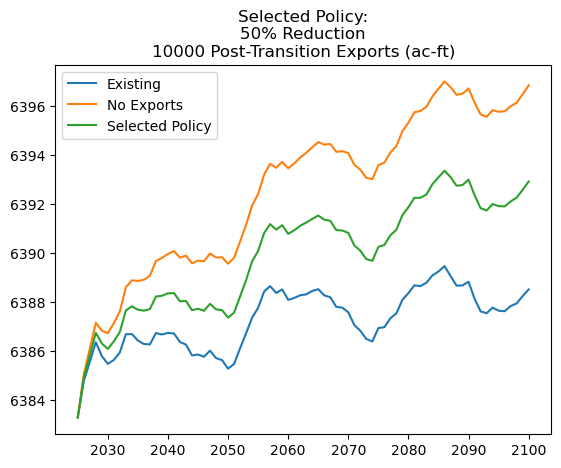

In [28]:
fig,ax=plt.subplots(1,1)
ax.plot(x,A1_mean_out,label='Existing')
ax.plot(x,no_exports_mean_out,label='No Exports')
ax.plot(x,selected_policy_mean_out,label='Selected Policy')
plt.title(f'Selected Policy:\n{Pre_Transition_Percent_Reduction}% Reduction\n{Post_Transition_Allowed} Post-Transition Exports (ac-ft)')
ax.legend()